In [2]:
import os
import sys
import data

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from options.test_options import TestOptions
from models.pix2pix_model import Pix2PixModel

# Initialize model

In [3]:
sys.argv = [sys.argv[0]]
sys.argv += '--name pretrained_vg_attributes_twostep --dataset_mode vg_sparse --embed_attributes --two_step_model --batchSize 1 --nThreads 0'.split(' ')
opt = TestOptions().parse()

----------------- Options ---------------
             aspect_ratio: 1.0                           
          attention_heads: 6                             
             attr_emb_dim: 64                            
                  attr_nc: 256                           
                batchSize: 1                             
     bert_embedding_level: -2                            
      cache_filelist_read: False                         
     cache_filelist_write: False                         
          checkpoints_dir: ./checkpoints                 
      concat_all_captions: False                         
                crop_size: 256                           
                 dataroot: ./datasets/cityscapes/        
             dataset_mode: vg_sparse                     	[default: coco_sparse]
          display_winsize: 256                           
         embed_attributes: True                          	[default: False]
           embed_captions: False                

In [4]:
dataloader = data.create_dataloader(opt)
dataset = dataloader.dataset

# debug_mode allows us to obtain structured instance information
dataset.debug_mode = True

# Lower the IoU threshold for NMS, which facilitates manipulation by merging duplicate detections
dataset.nms_iou = 0.5

Loading attribute json....
Images matched between COCO and VG: 0
dataset [VgSparseDataset] of size 8430 was created


In [5]:
model = Pix2PixModel(opt)
for param in model.parameters():
    param.requires_grad = False
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

Network [SPADEGenerator] was created. Total number of parameters: 78.3 million. To see the architecture, do print(network).
Network [SPADEfgGenerator] was created. Total number of parameters: 51.9 million. To see the architecture, do print(network).


## Build attribute index

In [6]:
from collections import Counter
from data.label_list import vg_labels

valid_labels = []
for i in list(dataloader.dataset.remapped_idx.keys())[1:]:
    valid_labels.append(vg_labels[i])
valid_labels = set(valid_labels)

# Build index of most likely attributes per class (for the dropdown list)
attribute_hist = {}
for label in valid_labels:
    attribute_hist[label] = Counter({x: 1 for x in dataloader.dataset.attr_map.keys()})
for i, path in enumerate(dataloader.dataset.image_paths):
    image_id = int(os.path.basename(path).split('.')[0])
    img = dataloader.dataset.vg_attributes[dataloader.dataset.indices[image_id]]
    for class_name, regions in img['region_db'].items():
        if class_name not in attribute_hist:
            continue
        for region in regions:
            if 'attribute_synsets' in region:
                for synset in region['attribute_synsets']:
                    if synset in dataloader.dataset.attr_map:
                        attribute_hist[class_name][synset] += 1
                        
for k, v in attribute_hist.items():
    attribute_hist[k] = [x for x, _ in v.most_common(32)]

# Interactive manipulation

In [7]:
import matplotlib
from matplotlib.widgets import TextBox
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from util.util import labelcolormap

cmap_arr = labelcolormap(opt.label_nc)
cmap = matplotlib.colors.ListedColormap(cmap_arr/255)

def class_hook(idx, label, mask):
    shift = (0, 0)
    if idx in edit_list:
        changes = edit_list[idx]
        if 'pos' in changes:
            shift = changes['pos']
        if 'class' in changes:
            label = changes['class']
            
    return label, shift

def attribute_hook(idx, label, attributes):
    if idx in edit_list and 'attributes' in edit_list[idx]:
        attributes.clear()
        attributes.extend(edit_list[idx]['attributes'])
    
dataset.attribute_hook = attribute_hook
dataset.class_hook = class_hook

<IPython.core.display.Javascript object>


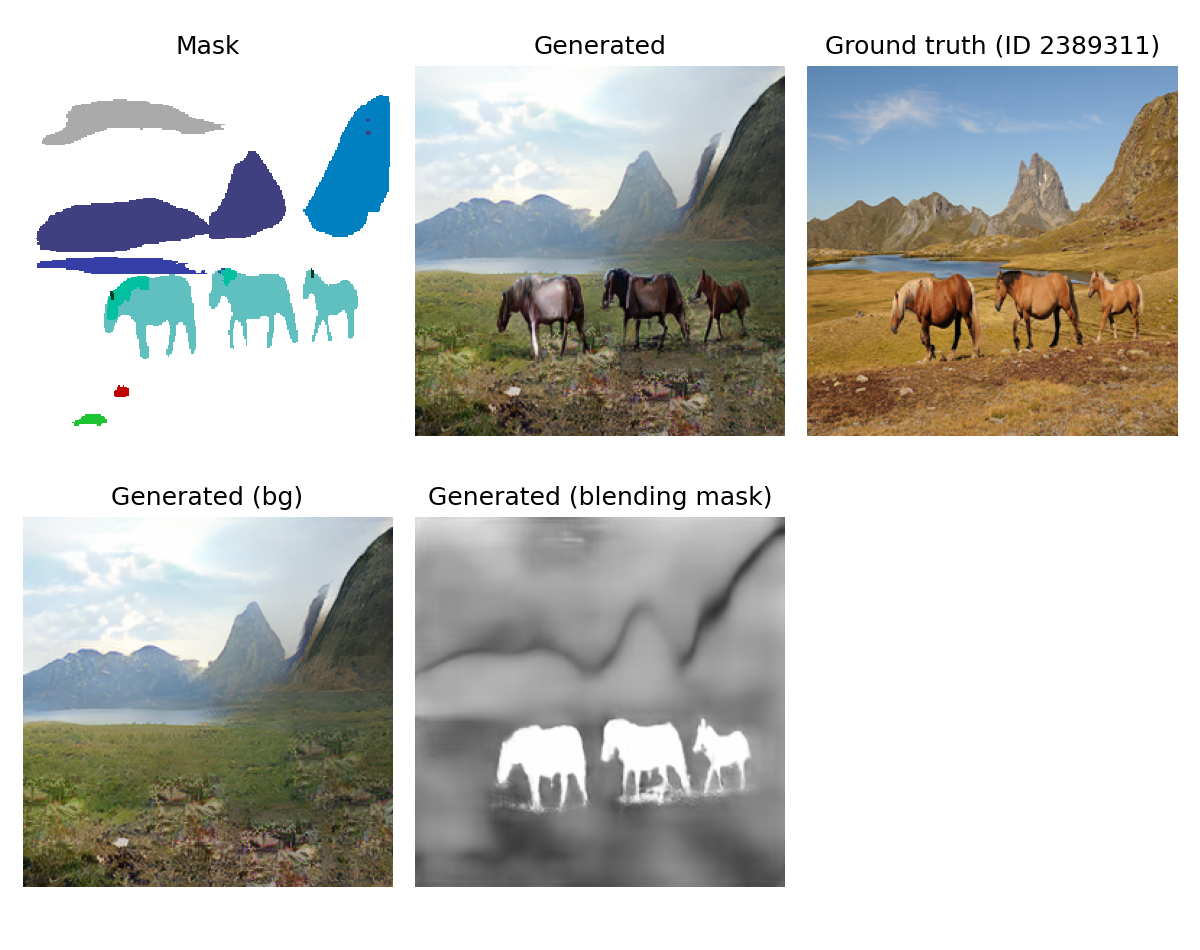

interactive(children=(Text(value='', description='Class'), Button(description='Run Interact', style=ButtonStyl…

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0, …

interactive(children=(Checkbox(value=False, description='Freeze background'), Output()), _dom_classes=('widget…

interactive(children=(SelectMultiple(description='Attributes', options=(), value=()), Button(description='Run …

<function __main__.update_attributes(attr_list)>

In [8]:
%matplotlib notebook

# Change this to manipulate another image
image_index = 6382

class_box = widgets.Text('', description='Class')
attr_box = widgets.SelectMultiple(options=[], value=[], description='Attributes')
x_slider = widgets.FloatSlider(min=-200, max=200, step=1, continuous_update=False)
y_slider = widgets.FloatSlider(min=-200, max=200, step=1, continuous_update=False)
freeze_bg = widgets.Checkbox(value=False, description='Freeze background')

selected_idx = None
edit_list = {}

class_box.value = ''
x_slider.value = 0
y_slider.value = 0
freeze_bg.value = False
attr_box.value = []
attr_box.options = []

canvas_size = 8
fig = plt.figure(6, figsize=(canvas_size, 2*canvas_size/3+1))
plt.subplots_adjust(wspace=0, hspace=0.03)

def batch_input(data_i):
    # Convert to a size 1 batch
    for k, v in data_i.items():
        if torch.is_tensor(v):
            data_i[k] = v.unsqueeze(0)
            if torch.cuda.is_available():
                data_i[k] = data_i[k].cuda()
        else:
            data_i[k] = [v]

with torch.no_grad():
    data_i = dataset[image_index]
    batch_input(data_i)
            
    image_id = int(os.path.basename(data_i['path'][0]).split('.')[0])

    debug_mask = dataset.debug_mask
    
    input_semantics_bg, input_semantics_fg, input_semantics, \
                input_attr_bg, input_attr_fg, input_attr, real_mask, \
                real_image, sentence, sentence_mask = model.preprocess_input(data_i)
    
    # Generate background
    generated_bg = model.netGbg(input_semantics_bg, input_attr_bg, input_semantics, input_attr, sentence, sentence_mask)
    
    # Best results for the background visualization are obtained by passing the generated
    # background image to the foreground generator with an empty semantic map
    zero_semantics = torch.zeros_like(input_semantics_fg)
    zero_semantics[:, 0] = 1
    generated_bg_, _ = model.netG(generated_bg, zero_semantics,
                                  torch.zeros_like(input_attr_fg), sentence, sentence_mask)
    
    # Generate foreground conditioned on the background
    generated, generated_mask = model.netG(generated_bg, input_semantics_fg, input_attr_fg, sentence, sentence_mask)

    
    yf = debug_mask.shape[0] / generated.shape[2]
    xf = debug_mask.shape[1] / generated.shape[3]

    # Mask
    plt.subplot(2, 3, 1)
    plt.title('Mask')
    m = data_i['label'].squeeze(0).squeeze(0).cpu().numpy()
    im_mask = plt.imshow(m, cmap=cmap, vmin=0, vmax=280, interpolation='nearest')
    plt.axis('off')
    ax = plt.gca()

    # Generation
    plt.subplot(2, 3, 2)
    plt.title('Generated')
    im = generated[0].permute(1, 2, 0).cpu().numpy()
    im = (im + 1)/2
    im_generated = plt.imshow(im)
    plt.axis('off')

    # Ground truth
    plt.subplot(2, 3, 3)
    plt.title('Ground truth (ID {})'.format(image_id))
    im2 = real_image[0].permute(1, 2, 0).cpu().numpy()
    im2 = (im2 + 1)/2
    im_gt = plt.imshow(im2)
    plt.axis('off')

    # Generation
    plt.subplot(2, 3, 4)
    plt.title('Generated (bg)')
    im3 = generated_bg_[0].permute(1, 2, 0).cpu().numpy()
    im3 = (im3 + 1)/2
    im_generated_bg = plt.imshow(im3)
    plt.axis('off')

    # Generation
    plt.subplot(2, 3, 5)
    plt.title('Generated (blending mask)')
    im4 = torch.sigmoid(generated_mask)[0].expand(3, -1, -1).permute(1, 2, 0).cpu().numpy()
    mask_generated = plt.imshow(im4)
    plt.axis('off')

fig.tight_layout()

def regenerate():
    global debug_mask, generated_bg, generated_bg_, m
    with torch.no_grad():
        data_i = dataset[image_index]
        m = data_i['label'].squeeze(0).cpu().numpy()
        im_mask.set_data(m)
        debug_mask = dataset.debug_mask
        
        batch_input(data_i)
        
        input_semantics_bg, input_semantics_fg, input_semantics, \
            input_attr_bg, input_attr_fg, input_attr, real_mask, \
            real_image, sentence, sentence_mask = model.preprocess_input(data_i)

        if not freeze_bg.value:
            generated_bg = model.netGbg(input_semantics_bg, input_attr_bg, input_semantics, input_attr, sentence, sentence_mask)
            zero_semantics = torch.zeros_like(input_semantics_fg)
            zero_semantics[:, 0] = 1
            generated_bg_, _ = model.netG(generated_bg, zero_semantics,
                                          torch.zeros_like(input_attr_fg), sentence, sentence_mask)
        
        generated, generated_mask = model.netG(generated_bg, input_semantics_fg, input_attr_fg, sentence, sentence_mask)
        
        im = generated[0].permute(1, 2, 0).cpu().numpy()
        im = (im + 1)/2
        im_generated.set_data(im)

        im3 = generated_bg_[0].permute(1, 2, 0).cpu().numpy()
        im3 = (im3 + 1)/2
        im_generated_bg.set_data(im3)
        
        im4 = torch.sigmoid(generated_mask)[0].expand(3, -1, -1).permute(1, 2, 0).cpu().numpy()
        mask_generated.set_data(im4)

def on_move(event):
    global debug_mask, m
    if event.inaxes and event.inaxes == ax:
        x = int(event.xdata)
        y = int(event.ydata)
        cl = m[y, x]
        ds = dataset
        val = debug_mask[int(y*yf), int(x*xf)]
        if val is not None:
            idx, attr_list = val
            ax.set_title(str(idx) + ' ' + ds.vg_labels[ds.remapped_idx_reverse[cl]] + ' ' + str(attr_list))
        else:
            ax.set_title('-')
    else:
        ax.set_title('')
        
def on_click(event):
    global selected_idx, debug_mask, m
    if event.inaxes and event.inaxes == ax:
        selected_idx = None
        
        x = int(event.xdata)
        y = int(event.ydata)
        cl = m[y, x]
        ds = dataset
        val = debug_mask[int(y*yf), int(x*xf)]
        idx, attr_list = val if val is not None else (None, None)
        class_name = ds.vg_labels[ds.remapped_idx_reverse[cl]]
        
        class_box.value = class_name
        
        if idx in edit_list and 'pos' in edit_list[idx]:
            x_slider.value, y_slider.value = edit_list[idx]['pos']
        else:
            x_slider.value = 0
            y_slider.value = 0
        
        # Update attribute list
        all_attr = list(attr_list)
        for attr in attribute_hist[class_name]:
            if attr not in attr_list:
                all_attr.append(attr)
        attr_box.options = all_attr
        attr_box.value = list(attr_list)
        
        selected_idx = idx
        
def on_change_class(new_class):
    
    if len(new_class) == 0:
        new_class = None # Delete object
        
    if selected_idx is not None:
        if selected_idx not in edit_list:
            edit_list[selected_idx] = {}
        edit_list[selected_idx]['class'] = new_class
        regenerate()
    
def update_pos(x, y):
    if selected_idx is not None:
        if selected_idx not in edit_list:
            edit_list[selected_idx] = {}
        edit_list[selected_idx]['pos'] = (y, x)
        regenerate()
    
def update_attributes(attr_list):
    if selected_idx is not None:
        if selected_idx not in edit_list:
            edit_list[selected_idx] = {}
        edit_list[selected_idx]['attributes'] = list(attr_list)
        regenerate()

def on_tick(new_tick):
    pass

fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('button_press_event', on_click)

interact_manual(on_change_class, new_class=class_box)
interact(update_pos, x=x_slider, y=y_slider)
interact(on_tick, new_tick=freeze_bg)
interact_manual(update_attributes, attr_list=attr_box)